# Linear regression using full-rank configurations

In this notebook, we assert that L-RVGA, LoFi with full-memory converge to the KF solution

In [2]:
import jax
import chex
import distrax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from rebayes.utils import datasets
from rebayes.base import RebayesParams
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga

In [3]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

## Dataset

In [49]:
num_train = 150
num_test = 1_000
num_features = 150

dgenerator = datasets.LRDataset(
    dim_inputs=num_features,
    sigma=1.0,
    scale=1.0,
    condition_number=1.0
)

key = jax.random.PRNGKey(314)
key_train, key_test = jax.random.split(key, 2)

gstate, (X_train, y_train) = dgenerator.sample_train(key_train, num_train)
X_test, y_test = dgenerator.sample_test(key_test, gstate, 1_000)

# num_projection = 150
# proj_matrix = jax.random.normal(key, (num_features, num_projection))
# proj_matrix = proj_matrix / jnp.linalg.norm(proj_matrix, "fro")

# X_train = jnp.einsum("nk,km->nm", X_train, proj_matrix)
# X_test = jnp.einsum("nk,km->nm", X_test, proj_matrix)

In [50]:
def tree_to_cpu(tree):
    return jax.tree_map(np.array, tree)

def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)

## Methods

### Setup

In [51]:
def callback(bel, pred_obs, *args, **kwargs):

    return {
        "mean": bel.mean,
    }

In [52]:
class LReg(nn.Module):
    activation: Callable = nn.elu
    
    def setup(self):
        self.mean = nn.Dense(1, use_bias=False)
    
    @nn.compact
    def __call__(self, x):
        """
        Link_fn: h(θ, x) = θ^T x
        """
        mean = self.mean(x)
        return mean

In [53]:
model = LReg()

### Time Eval

In [54]:
agents = {}
outputs = {}
hists = {}
times = {}

#### L-RVGA

In [55]:
def fwd_link(mean, bel, x):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2

def log_prob(mean, bel, x, y):
    yhat, std = fwd_link(mean, bel, x)
    std = jnp.sqrt(std)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [56]:
hparams = {
    "sigma2": 1.0,
    "eps": 1e-3 # 1e-8 gets rounded to 1.0
}

std = 1.0
key = jax.random.PRNGKey(3141)
dim_rank = num_features
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train, dim_rank, std, **hparams)
bel_init = bel_init.replace(mu=bel_init.mu * 0.0)

In [57]:
def emission_mean_fn(w, x):
    w = reconstruct_fn(w)
    yhat = model.apply(w, x).ravel()
    return yhat

In [58]:
name_agent = f"L-RVGA"
agent = lrvga.LRVGA(fwd_link, log_prob, n_samples=30, n_outer=1, n_inner=3)
output, hist = agent.scan(X_train, y_train, callback=callback, bel=bel_init, progress_bar=True)

hists[name_agent] = hist
agents[name_agent] = agent
outputs[name_agent] = output

#### Kalman Filter

In [59]:
initial_mean = jnp.zeros(num_features)
dynamics_covariance = 0.0
initial_covariance = 1.0
dynamics_weights = 1.0

def emission_cov_fn(w, x): return 1.0

def emission_mean_fn(w, x):
    w = reconstruct_fn(w)
    yhat = model.apply(w, x).ravel()
    return yhat

  0%|          | 0/150 [00:00<?, ?it/s]

In [60]:
params = RebayesParams(
    initial_mean,
    initial_covariance,
    dynamics_weights,
    dynamics_covariance,
    emission_mean_fn,
    emission_cov_fn
)

In [61]:
name_agent = "KF"


agent = ekf.RebayesEKF(params, method="fcekf")
output, hist = agent.scan(X_train, y_train, callback=callback)

hists[name_agent] = hist
agents[name_agent] = agent
outputs[name_agent] = output

  0%|          | 0/150 [00:00<?, ?it/s]

#### LoFi

In [62]:
memory_size = num_features
name_agent = f"LoFi full"
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(memory_size)
agent = lofi.RebayesLoFi(params, params_lofi, method)
output, hist = agent.scan(X_train, y_train, callback=callback)

hists[name_agent] = hist
agents[name_agent] = agent
outputs[name_agent] = output

#### LoFi-orth

In [63]:
memory_size = num_features
name_agent = f"LoFi orth"
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(memory_size)
agent = lofi.RebayesLoFi(params, params_lofi, method)
output, hist = agent.scan(X_train, y_train, callback=callback)

hists[name_agent] = hist
agents[name_agent] = agent
outputs[name_agent] = output

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

#### ORFit

In [64]:
memory_size = num_features
name_agent = "ORFit"
method = "orfit"
params_lofi = lofi.LoFiParams(memory_size)
agent = lofi.RebayesLoFi(params, params_lofi, method)
output, hist = agent.scan(X_train, y_train, callback=callback)

hists[name_agent] = hist
agents[name_agent] = agent
outputs[name_agent] = output

  0%|          | 0/150 [00:00<?, ?it/s]

### Test methods

In [65]:
def hist_rmse(params):
    X, y = X_train, y_train
    
    yhat_hist = jax.vmap(emission_mean_fn, in_axes=(0, None))(params, X)
    rmse = jnp.sqrt(jnp.power(yhat_hist - y.T, 2).mean(axis=-1))
    return rmse

In [66]:
rmses = get_subtree(hists, "mean")
rmses = jax.tree_map(hist_rmse, rmses)
rmses = tree_to_cpu(rmses)
rmses = pd.DataFrame(rmses)

In [74]:
rmses.tail()

,KF,L-RVGA,LoFi full,LoFi orth,ORFit
145,0.686392,1.337806,0.686397,0.872191,1.610572
146,0.681817,1.337279,0.681821,0.879822,1.328967
147,0.681896,1.335471,0.681900,0.873541,1.714241
148,0.679903,1.326345,0.679908,0.862795,3.157063
149,0.633624,1.313707,0.633627,0.815826,0.003177


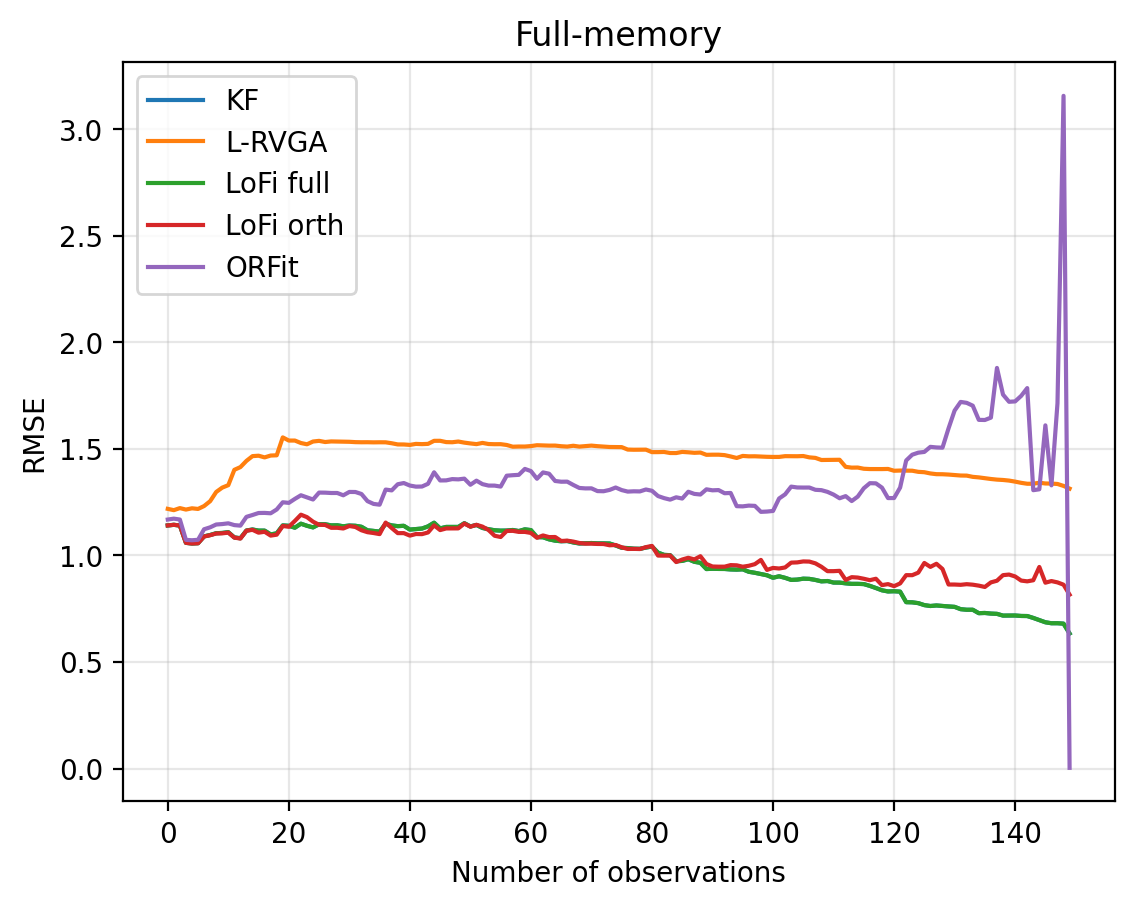

In [68]:
rmses.drop([], axis=1).plot()
plt.xlabel("Number of observations")
plt.ylabel("RMSE")
plt.title("Full-memory")
ymin, _ = plt.ylim()
# plt.ylim(0.96, 1.1)
plt.grid(alpha=0.3)

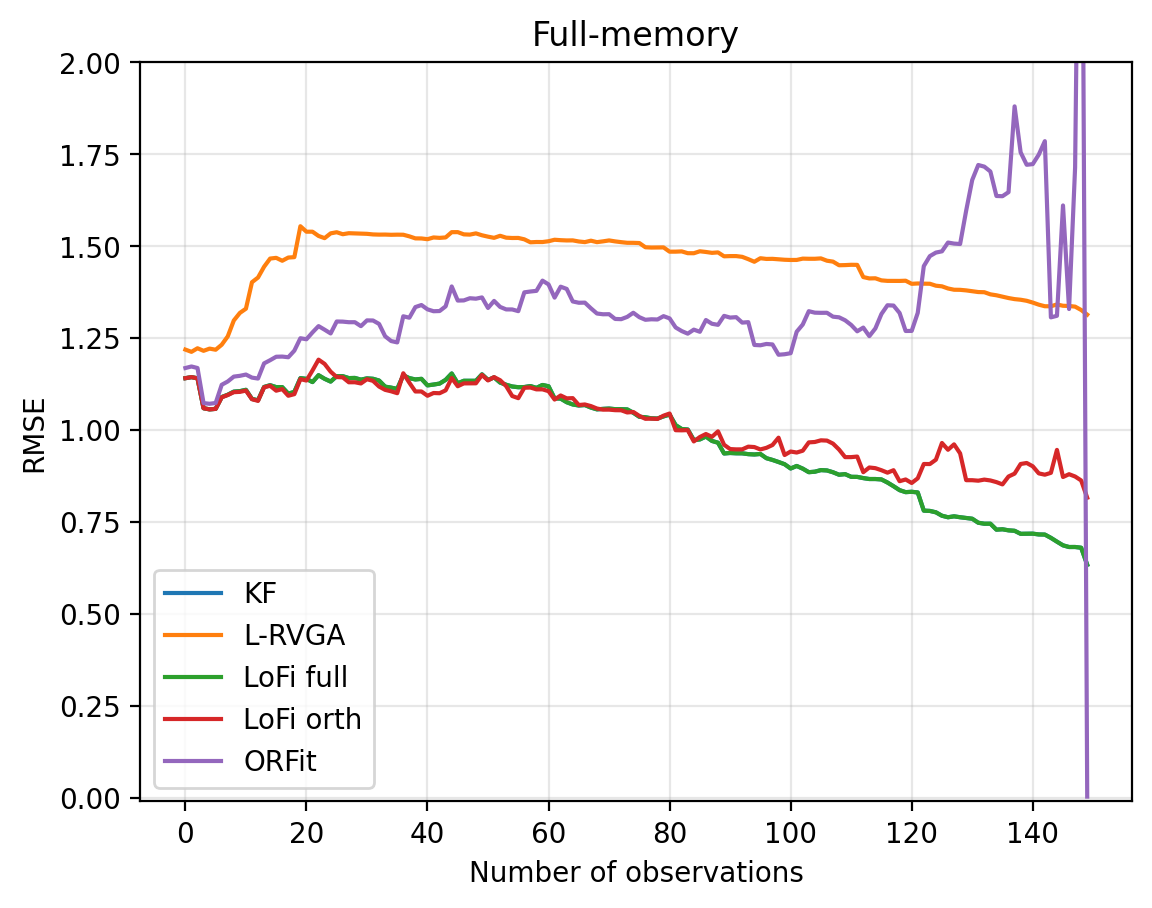

In [73]:
rmses.iloc[:150].drop([], axis=1).plot()
plt.xlabel("Number of observations")
plt.ylabel("RMSE")
plt.title("Full-memory")
ymin, _ = plt.ylim()
plt.ylim(-0.01, 2.0)
plt.grid(alpha=0.3)